# Reservoir computing clásico y cuántico en EEG simulados.

## Carga de librerías.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt
from sklearn.cluster import KMeans
import pandas as pd
import random

## Carga de los datos.

In [2]:
# Carga de datos.
eeg_synthetic = np.load("./data/data/synthetic_data_auto.npy")

(40, 2000, 10)


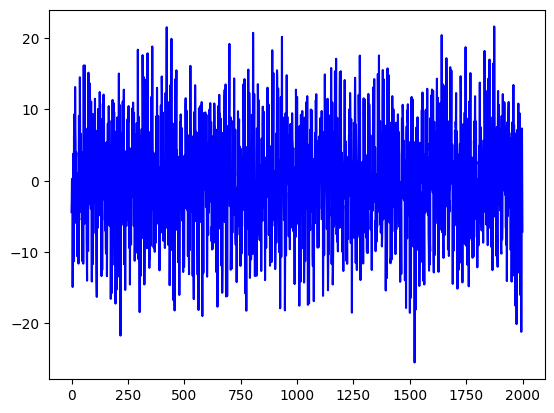

In [3]:
# Cogemos el EEG sintético de un joven.
print(eeg_synthetic.shape)
sujeto_synt = eeg_synthetic[0,:,:]

plt.plot(range(sujeto_synt.shape[0]), sujeto_synt[:,0], color = 'blue')
plt.show()

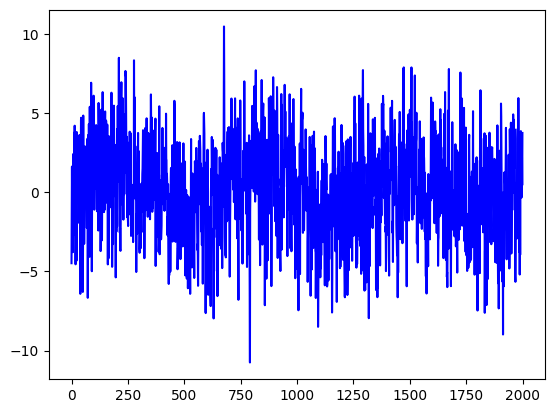

In [4]:
# Cogemos el EEG sintético de un adulto.
sujeto_synt_adult = eeg_synthetic[21,:,:]

plt.plot(range(sujeto_synt_adult.shape[0]), sujeto_synt_adult[:,0], color = 'blue')
plt.show()

## RC clásico Sujeto Joven.

In [5]:
# Implementación reservoir clásico con un sujeto joven.

# Parámetros
num_input_channels = 10     # Dimensionalidad de entrada (10 canales)
num_reservoir_neurons = 80   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = sujeto_synt.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ sujeto_synt[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS_clasico_joven_synt = reservoir_states - np.mean(reservoir_states, axis = 1, keepdims=True)
print(RS_clasico_joven_synt.shape)
analytic_signal = hilbert(RS_clasico_joven_synt)
amplitude_envelope_clasico_joven_synt = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS_clasico_joven_synt.shape)
print(amplitude_envelope_clasico_joven_synt.shape)

(80, 2001)
(80, 2001)
(80, 2001)
(80, 2001)


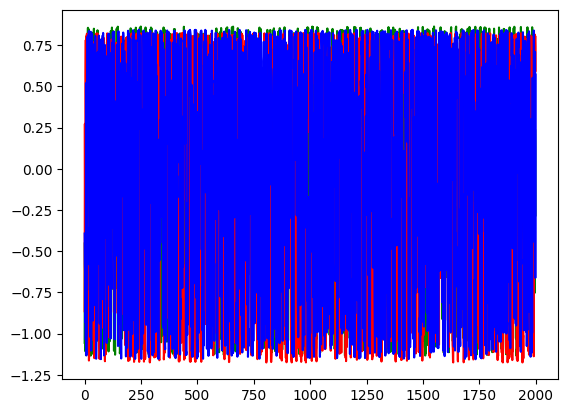

In [6]:
plt.plot(range(sujeto_synt.shape[0]), RS_clasico_joven_synt[0, 1:], color = 'green')
plt.plot(range(sujeto_synt.shape[0]), RS_clasico_joven_synt[1, 1:], color = 'red')
plt.plot(range(sujeto_synt.shape[0]), RS_clasico_joven_synt[2, 1:], color = 'blue')
plt.show()

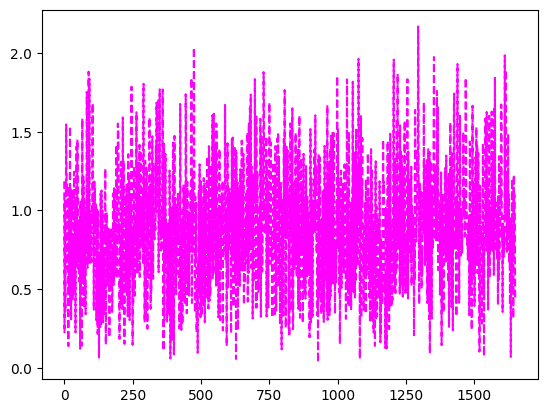

In [7]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(300, amplitude_envelope_clasico_joven_synt.shape[1])
input_sequence_clasico_joven_synt = amplitude_envelope_clasico_joven_synt[:, stable_start:-50]
plt.plot(input_sequence_clasico_joven_synt[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [8]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_clasico_joven_synt.T)

# Resultados
idx_clasico_joven_synt = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx_clasico_joven_synt.shape)

Centroides de los clústeres:
[[0.85465238 1.0161081  1.03534088 0.96368105 0.93255216 1.05469944
  0.77598435 0.97492169 0.930603   0.55537229 0.65890575 0.61040215
  0.97970764 0.83058652 0.83576602 0.76889452 0.86845089 1.00930583
  0.90530987 0.7359428  0.85292127 0.80780949 0.77452763 0.84243366
  0.77066966 0.90614137 0.49886532 0.75616083 0.83127583 0.97006409
  0.9053933  0.84951733 1.03703414 1.23729939 0.91801596 0.82101722
  0.92445437 0.76306339 1.19908262 0.8899061  0.82833223 1.23209568
  0.83381311 0.85755025 0.96095068 0.82479071 1.05451307 0.87219277
  1.16949032 0.86897973 1.06048587 0.84400453 0.86208303 0.88423061
  0.81336295 0.62223795 0.8848679  0.56902806 0.72460375 1.06898429
  0.94832574 0.58056838 1.07082773 0.76299047 0.84586406 0.98014801
  0.89784372 0.72513822 0.99750983 0.61458731 0.75020058 0.90005379
  0.97465147 1.19662996 0.94947354 0.89495957 0.83356091 0.6832559
  0.68362089 0.88679191]
 [0.92200474 0.89299676 0.94042737 1.10040394 0.95336734 1.0634

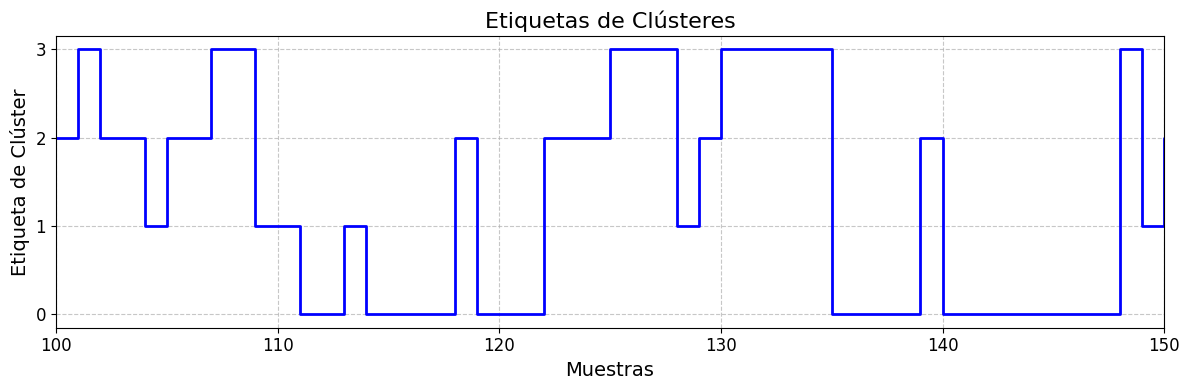

In [9]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_clasico_joven_synt.shape[1]), idx_clasico_joven_synt, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.xlim([100,150])
plt.tight_layout() 
plt.show()

### Clasificador Random Forest Clásico.

In [21]:
def reservoir_computing_clasico(sujeto_synt, num_input_channels=10, num_reservoir_neurons=80):  
    """  
    Implementación de un reservorio clásico.  

    Args:  
    - sujeto_synt: array de forma (num_muestras, num_input_channels) con los datos de entrada.  
    - num_input_channels: Dimensionalidad de entrada (número de canales). Default es 10.  
    - num_reservoir_neurons: Número de neuronas en el reservorio. Default es 80.  
    - num_readout_neurons: Número de neuronas de salida. Default es 1.  

    Returns:  
    - input_sequence: Secuencia de entrada procesada.  
    """  
    num_training_samples = sujeto_synt.shape[0]  # Número de muestras de entrenamiento  

    # Generar pesos de entrada al reservorio  
    input2res = np.random.randn(num_reservoir_neurons, num_input_channels)  

    # Generar pesos recurrentes del reservorio  
    res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)  

    # Normalizar las columnas de los pesos recurrentes  
    res2res = res2res / np.linalg.norm(res2res, axis=0)  

    # Sesgo del reservorio  
    input_bias = np.random.rand(num_reservoir_neurons, 1)  

    # Estados iniciales del reservorio  
    reservoir_states = np.random.randn(num_reservoir_neurons, num_training_samples + 1)  

    # Dinámicas del reservorio  
    for i in range(num_training_samples):  
        reservoir_states[:, i + 1] = np.tanh(  
            (0.05 * input2res @ sujeto_synt[i, :]) +  
            (0.95 * res2res @ reservoir_states[:, i]) +  
            input_bias.flatten()  
        )  

    # Extracción de la envolvente superior usando la transformada de Hilbert  
    RS_clasico_joven_synt = reservoir_states - np.mean(reservoir_states, axis=1, keepdims=True)  
    analytic_signal = hilbert(RS_clasico_joven_synt)  
    amplitude_envelope_clasico_joven_synt = np.abs(analytic_signal)  

    # Eliminamos los primeros puntos para estabilizar el reservorio  
    stable_start = min(300, amplitude_envelope_clasico_joven_synt.shape[1])  
    input_sequence = amplitude_envelope_clasico_joven_synt[:, stable_start:-50]  

    return input_sequence  

In [22]:
def clustering(input_sequence, num_clusters=4):  
    """  
    Función para realizar agrupamiento usando K-Means.  

    Args:  
    - input_sequence: Array de entrada procesado para el agrupamiento.  
    - num_clusters: Número de estados cerebrales. Default es 4.  

    Returns:  
    - labels: Etiquetas de los clústeres asignados a cada muestra de entrada.  
    """  
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)  
    kmeans.fit(input_sequence.T)  # Transponer para obtener las muestras en filas  
    labels = kmeans.labels_  
    return labels  

In [ ]:
# Sujetos jóvenes.
sujeto_synt_joven2 = eeg_synthetic[3,:,:]
sujeto_synt_joven3 = eeg_synthetic[6,:,:]
sujeto_synt_joven4 = eeg_synthetic[9,:,:]
sujeto_synt_joven5 = eeg_synthetic[12,:,:]

# Sujetos adultos.
sujeto_synt_adult2 = eeg_synthetic[25,:,:]
sujeto_synt_adult3 = eeg_synthetic[28,:,:]
sujeto_synt_adult4 = eeg_synthetic[31,:,:]
sujeto_synt_adult5 = eeg_synthetic[34,:,:]

# RC en señales jóvenes.
input_sequence_clasico_joven2_synt = reservoir_computing_clasico(sujeto_synt_joven2)
input_sequence_clasico_joven3_synt = reservoir_computing_clasico(sujeto_synt_joven3)
input_sequence_clasico_joven4_synt = reservoir_computing_clasico(sujeto_synt_joven4)
input_sequence_clasico_joven5_synt = reservoir_computing_clasico(sujeto_synt_joven5)

# RC en señales adultas.
input_sequence_clasico_adult2_synt = reservoir_computing_clasico(sujeto_synt_adult2)
input_sequence_clasico_adult3_synt = reservoir_computing_clasico(sujeto_synt_adult3)
input_sequence_clasico_adult4_synt = reservoir_computing_clasico(sujeto_synt_adult4)
input_sequence_clasico_adult5_synt = reservoir_computing_clasico(sujeto_synt_adult5)

# Clustering en señales jóvenes.
idx_clasico_joven2_synt = clustering(input_sequence_clasico_joven2_synt)
idx_clasico_joven3_synt = clustering(input_sequence_clasico_joven3_synt)
idx_clasico_joven4_synt = clustering(input_sequence_clasico_joven4_synt)
idx_clasico_joven5_synt = clustering(input_sequence_clasico_joven5_synt)

# Clustering en señales adultas.
idx_clasico_adult2_synt = clustering(input_sequence_clasico_adult2_synt)
idx_clasico_adult3_synt = clustering(input_sequence_clasico_adult3_synt)
idx_clasico_adult4_synt = clustering(input_sequence_clasico_adult4_synt)
idx_clasico_adult5_synt = clustering(input_sequence_clasico_adult5_synt)

In [27]:
all_cluster_sequences = [idx_clasico_joven_synt,idx_clasico_joven2_synt,idx_clasico_joven3_synt,idx_clasico_joven4_synt,
                         idx_clasico_joven5_synt,idx_clasico_adult_synt, idx_clasico_adult2_synt, idx_clasico_adult3_synt,
                         idx_clasico_adult4_synt, idx_clasico_adult5_synt]

In [30]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Imagina que 'all_cluster_sequences' tiene 40 secuencias (20 jóvenes + 20 adultos)
# Cada secuencia es un array de clusters de longitud variable

# Simulamos (para el ejemplo)
# all_cluster_sequences = [np.array([1,2,2,3,4,...]), np.array([2,3,3,1,4,...]), ...]

n_clusters = 4  # Número de clusters
X = []

for cluster_sequence in all_cluster_sequences:
    hist, _ = np.histogram(cluster_sequence, bins=np.arange(0, n_clusters))
    hist_normalized = hist / np.sum(hist)  # Normalizar para obtener proporciones
    X.append(hist_normalized)

X = np.array(X)

# Etiquetas: 0 para jóvenes, 1 para adultos
y = np.array([0]*5 + [1]*5)

# Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar un clasificador
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

# Evaluar
y_pred = clf.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



## RC Cuántico Sujeto Joven.

In [10]:
# Definir parámetros principales
num_qubits = 5 # hacemos uso de 5 qubits
num_channels = 10  # Número de canales

# Dispositivo cuántico
dev = qml.device("default.qubit", wires=num_qubits)

def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""  
    for i in range(num_qubits):
        qml.RX(reservoir_weights[i, i], wires=i)

    if connectivity == 'ring':  
        for j in range(num_qubits - 1):  
            qml.CNOT(wires=[j, j+1])  
    
    elif connectivity == 'star':  
        central_qubit = 0
        for j in range(1, num_qubits):  
            qml.CNOT(wires=[central_qubit, j])  

    elif connectivity == 'random':  
        qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]  
        random.shuffle(qubit_pairs)  
        for j, k in qubit_pairs[num_qubits // 2]:  
            qml.CNOT(wires=[j, k])  
    
    elif connectivity == 'full':  
        for j in range(num_qubits):  
            for k in range(j + 1, num_qubits):  
                qml.CNOT(wires=[j, k])  

@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN) con 2 qubits activos por canal."""
    for i in range(num_qubits):
        qml.RX(0.05 * weights_in[i,:] @ input_data[:] + 0.95 * weights_rc[i,i] * prev_output[i], wires=i)
    
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    return qml.probs(wires=range(num_qubits)) 

In [11]:
# Inicialización de pesos
weights_in = np.random.uniform(-np.pi, np.pi, (num_qubits, num_channels))
weights_rc = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

# Señal con múltiples canales
input_series = sujeto_synt
time_steps = input_series.shape[0]

shape_qubits = 32

outputs = np.zeros((time_steps, shape_qubits))  # Salida esperada
prev_output = np.zeros((shape_qubits))  # Estado anterior de salida

# Loop de propagación en el tiempo
for t in range(time_steps):
    q_probs = quantum_echo_state_network(input_series[t,:], prev_output[:], weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_probs)
    outputs[t,:] = final_output
    prev_output[:] = final_output  # Actualizar el estado anterior
    print(f"Step {t}: {outputs[t,:]}")

Step 0: [2.56748550e-01 1.78503320e-01 2.03312332e-02 2.95874713e-02
 1.39059655e-03 2.02400644e-03 1.79583397e-02 1.23389948e-02
 7.16168869e-04 1.04238082e-03 9.24942161e-03 6.35491959e-03
 1.34434918e-01 9.26596123e-02 1.04718107e-02 1.52410568e-02
 1.81327652e-04 2.63921692e-04 2.34193424e-03 1.60902970e-03
 3.42316562e-02 2.35237444e-02 2.65146054e-03 3.85918044e-03
 6.63963392e-02 4.56531240e-02 5.14835238e-03 7.49333291e-03
 3.52086959e-04 5.12461183e-04 4.54735031e-03 3.12427273e-03]
Step 1: [3.37488129e-02 2.93541090e-03 5.55383654e-04 6.38764171e-03
 5.11980380e-04 5.88845898e-03 3.11131147e-02 2.70600945e-03
 2.33945197e-05 2.69071339e-04 1.42214595e-03 1.23649152e-04
 1.54270860e-03 1.34131544e-04 2.53777968e-05 2.91881937e-04
 2.43354956e-04 2.79893225e-03 1.47924072e-02 1.28622509e-03
 1.60462308e-02 1.39526505e-03 2.63985440e-04 3.03621112e-03
 3.37435774e-01 3.05253937e-02 5.77715974e-03 6.63489454e-02
 5.32568309e-03 6.11772649e-02 3.12893730e-01 2.81411445e-02]
Step 2

In [12]:
outputs = outputs.T
outputs.shape

(32, 2000)

In [13]:
RS_cuantico_eeg_simulado_joven = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_eeg_simulado_joven.shape)

(32, 2000)


In [14]:
# Aplicamos la transformada de Hilbert a los estados del reservoir.
analytic_signal = hilbert(RS_cuantico_eeg_simulado_joven)
amplitude_envelope_eeg_simulado_joven= np.abs(analytic_signal)

print(analytic_signal.shape)
print(amplitude_envelope_eeg_simulado_joven.shape)

(32, 2000)
(32, 2000)


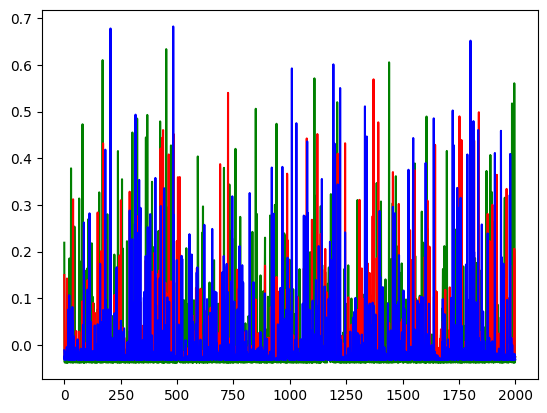

In [15]:
plt.plot(range(sujeto_synt.shape[0]), RS_cuantico_eeg_simulado_joven [0,:], color = 'green')
plt.plot(range(sujeto_synt.shape[0]), RS_cuantico_eeg_simulado_joven [1,:], color = 'red')
plt.plot(range(sujeto_synt.shape[0]), RS_cuantico_eeg_simulado_joven [2,:], color = 'blue')
plt.show()

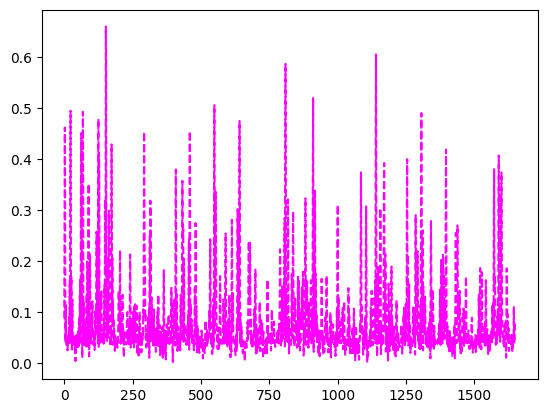

In [16]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(300, amplitude_envelope_eeg_simulado_joven.shape[1])
input_sequence_cuant_eeg_simulado_joven = amplitude_envelope_eeg_simulado_joven[:,stable_start:-50]
plt.plot(input_sequence_cuant_eeg_simulado_joven[0,:], linestyle="dashed", color = 'magenta')
plt.show()

In [17]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuant_eeg_simulado_joven.T)

# Resultados
idx_cuantico_simulado_joven = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx_cuantico_simulado_joven.shape)

Centroides de los clústeres:
[[0.06624151 0.04795258 0.05314816 0.07693656 0.04754189 0.11520194
  0.09472375 0.04858632 0.06815618 0.17898907 0.13012443 0.06065942
  0.07639652 0.05375159 0.05761082 0.08386457 0.05707843 0.11727937
  0.09154789 0.05188046 0.06909624 0.04469167 0.05707723 0.07977114
  0.07210768 0.04370218 0.04019662 0.06502923 0.04195435 0.1030458
  0.09138017 0.04027137]
 [0.07620695 0.05073968 0.06206327 0.09200828 0.03871921 0.04997205
  0.05489455 0.03652289 0.04547857 0.08397663 0.08039862 0.04808357
  0.19304259 0.06917696 0.08045468 0.24812792 0.04166388 0.05050887
  0.05434026 0.04186406 0.10581261 0.04720215 0.06221354 0.11654651
  0.07250504 0.03850128 0.04967915 0.07068991 0.0312171  0.04488426
  0.04531113 0.03131129]
 [0.14614731 0.0634729  0.06822121 0.15728247 0.03524838 0.05913335
  0.06773166 0.03731586 0.0426762  0.05780697 0.06558162 0.04898767
  0.07965466 0.05845192 0.06082602 0.08429494 0.04213439 0.05577574
  0.06293183 0.04836342 0.09389467 0.0

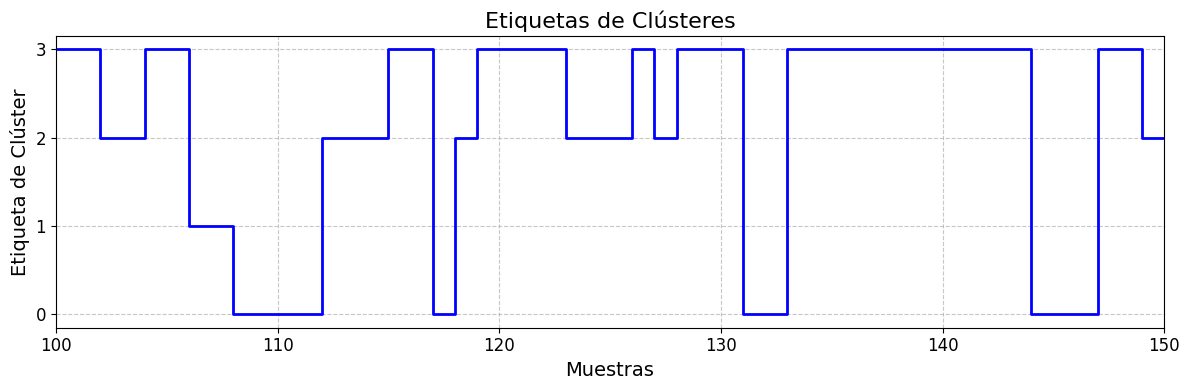

In [18]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant_eeg_simulado_joven.shape[1]), idx_cuantico_simulado_joven, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.xlim([100,150])
plt.tight_layout() 
plt.show()

## RC Clásico Sujeto Adulto.

In [24]:
# Implementación reservoir clásico con un sujeto adulto.

# Parámetros
num_input_channels = 10     # Dimensionalidad de entrada (10 canales)
num_reservoir_neurons = 80   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = sujeto_synt_adult.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ sujeto_synt_adult[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS_clasico_adult_synt = reservoir_states - np.mean(reservoir_states, axis = 1, keepdims=True)
print(RS_clasico_adult_synt.shape)
analytic_signal = hilbert(RS_clasico_adult_synt)
amplitude_envelope_clasico_adult_synt = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS_clasico_adult_synt.shape)
print(amplitude_envelope_clasico_adult_synt.shape)

(80, 2001)
(80, 2001)
(80, 2001)
(80, 2001)


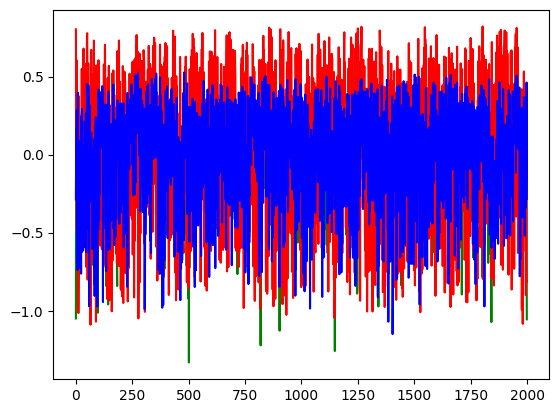

In [36]:
plt.plot(range(sujeto_synt_adult.shape[0]), RS_clasico_adult_synt[0, 1:], color = 'green')
plt.plot(range(sujeto_synt_adult.shape[0]), RS_clasico_adult_synt[1, 1:], color = 'red')
plt.plot(range(sujeto_synt_adult.shape[0]), RS_clasico_adult_synt[2, 1:], color = 'blue')
plt.show()

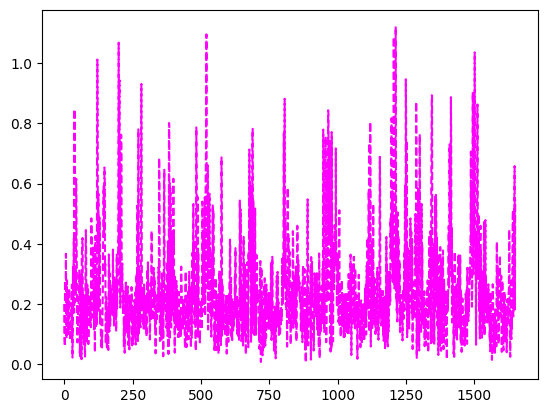

In [25]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(300, amplitude_envelope_clasico_adult_synt.shape[1])
input_sequence_clasico_adult_synt = amplitude_envelope_clasico_adult_synt[:, stable_start:-50]
plt.plot(input_sequence_clasico_adult_synt[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [26]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_clasico_adult_synt.T)

# Resultados
idx_clasico_adult_synt = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx_clasico_adult_synt.shape)

Centroides de los clústeres:
[[0.30495251 0.51164413 0.71727459 0.28382538 0.71493653 0.63112222
  0.74965353 0.47097582 0.59693184 0.50523665 0.62052186 0.31910556
  0.60751259 0.5468011  0.63741589 0.56972662 0.47286471 0.61311658
  0.45208943 0.63426556 0.66524239 0.56840113 0.39503433 0.49962413
  0.67335792 0.65070668 0.16515564 0.63153571 0.38074978 0.4719637
  0.6576121  0.64498649 0.62642186 0.23442925 0.82064082 0.53334316
  0.66939747 0.55980655 0.33232556 0.18849986 0.78141231 0.59480443
  0.36095204 0.75938853 0.27547415 0.48906702 0.36735004 0.52153672
  0.56784515 0.62861897 0.39241632 0.39821744 0.51596754 0.38983471
  0.52756916 0.62298891 0.56161611 0.74209939 0.4745959  0.36671235
  0.68002582 0.54788999 0.55761858 0.42496896 0.67857749 0.4598917
  0.47485063 0.68145798 0.6461145  0.81044991 0.85813809 0.66033543
  0.52011658 0.59020972 0.54742409 0.62874497 0.74013304 0.51727855
  0.62944499 0.69354866]
 [0.22039818 0.42487174 0.57379789 0.20491465 0.55191789 0.33155

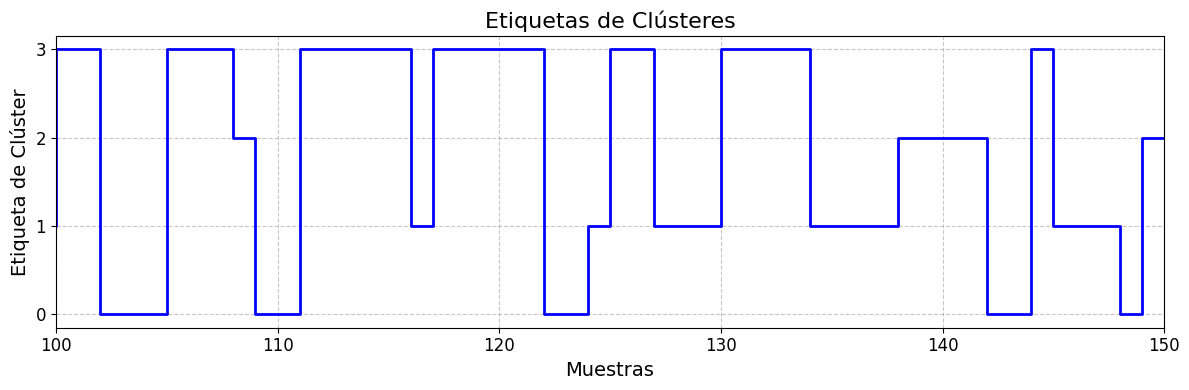

In [43]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_clasico_adult_synt.shape[1]), idx_clasico_adult_synt, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.xlim([100,150])
plt.tight_layout() 
plt.show()

## RC Cuántico Sujeto Adulto

In [44]:
# Inicialización de pesos
weights_in = np.random.uniform(-np.pi, np.pi, (num_qubits, num_channels))
weights_rc = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

# Señal con múltiples canales
input_series = sujeto_synt_adult
time_steps = input_series.shape[0]

shape_qubits = 8

outputs = np.zeros((time_steps, shape_qubits))  # Salida esperada
prev_output = np.zeros((shape_qubits))  # Estado anterior de salida

# Loop de propagación en el tiempo
for t in range(time_steps):
    q_probs = quantum_echo_state_network(input_series[t,:], prev_output[:], weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_probs)
    outputs[t,:] = final_output
    prev_output[:] = final_output  # Actualizar el estado anterior
    print(f"Step {t}: {outputs[t,:]}")

Step 0: [0.05486253 0.00369124 0.00214265 0.03186708 0.02098569 0.3024973
 0.49144006 0.0361427 ]
Step 1: [0.08673834 0.02492626 0.0076497  0.02667512 0.04463799 0.15454542
 0.4681853  0.14455563]
Step 2: [0.29381571 0.04635275 0.00103296 0.00674149 0.00186131 0.01214722
 0.49714675 0.0833898 ]
Step 3: [0.11541212 0.07436215 0.128951   0.19908887 0.11824171 0.18278289
 0.10580834 0.06814569]
Step 4: [0.12199688 0.19641769 0.18166246 0.11269886 0.11283091 0.06969997
 0.07548477 0.1221396 ]
Step 5: [0.1000526  0.02088145 0.0157927  0.07577385 0.05829488 0.2733978
 0.35482161 0.07701821]
Step 6: [1.22944804e-01 4.66346115e-02 1.60663898e-08 4.25409941e-08
 7.83094049e-08 2.07349627e-07 5.38679830e-01 2.23623745e-01]
Step 7: [0.09204947 0.00858854 0.00094629 0.01017029 0.00750137 0.08045105
 0.62414794 0.06798022]
Step 8: [0.02022016 0.00348533 0.00122817 0.00712606 0.03706024 0.21187343
 0.5444854  0.10483244]
Step 9: [0.11827989 0.03066995 0.0121508  0.04703325 0.0460305  0.17655391
 0.4

In [45]:
outputs = outputs.T
outputs.shape

(8, 2000)

In [46]:
RS_cuantico_eeg_simulado_adulto = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_eeg_simulado_adulto.shape)

(8, 2000)


In [47]:
# Aplicamos la transformada de Hilbert a los estados del reservoir.
analytic_signal = hilbert(RS_cuantico_eeg_simulado_adulto)
amplitude_envelope_eeg_simulado_adulto = np.abs(analytic_signal)

print(analytic_signal.shape)
print(amplitude_envelope_eeg_simulado_adulto.shape)

(8, 2000)
(8, 2000)


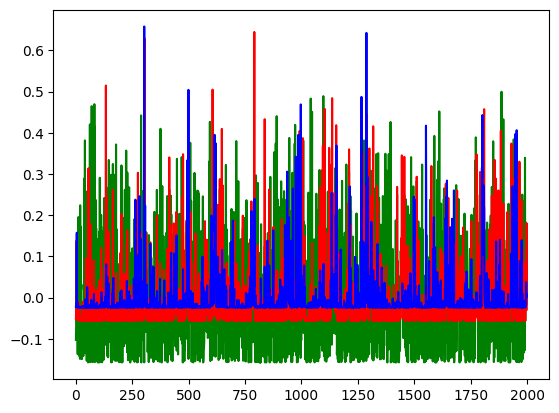

In [49]:
plt.plot(range(sujeto_synt_adult.shape[0]), RS_cuantico_eeg_simulado_adulto [0, :], color = 'green')
plt.plot(range(sujeto_synt_adult.shape[0]), RS_cuantico_eeg_simulado_adulto [1, :], color = 'red')
plt.plot(range(sujeto_synt_adult.shape[0]), RS_cuantico_eeg_simulado_adulto [2, :], color = 'blue')
plt.show()

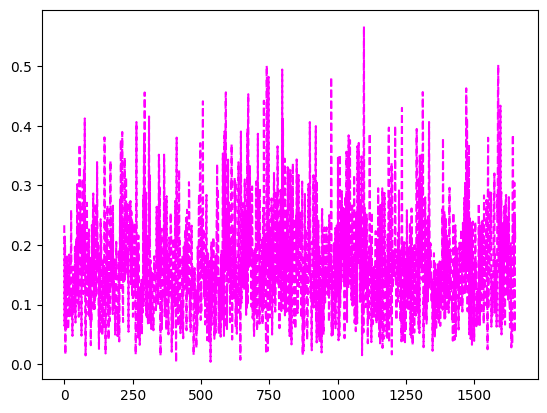

In [50]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(300, amplitude_envelope_eeg_simulado_adulto.shape[1])
input_sequence_cuant_eeg_simulado_adulto = amplitude_envelope_eeg_simulado_adulto[:,stable_start:-50]
plt.plot(input_sequence_cuant_eeg_simulado_adulto[0,:], linestyle="dashed", color = 'magenta')
plt.show()

In [51]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuant_eeg_simulado_adulto.T)

# Resultados
idx_cuantico_simulado_adulto = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx_cuantico_simulado_adulto.shape)

Centroides de los clústeres:
[[0.13477716 0.06453475 0.03458033 0.05723171 0.03941623 0.12126493
  0.15680938 0.10444781]
 [0.19319676 0.10557406 0.04712846 0.07838412 0.05402012 0.12692319
  0.32672059 0.10023575]
 [0.19837635 0.10264839 0.0440724  0.09058702 0.07298127 0.35358485
  0.27420352 0.095294  ]
 [0.16365247 0.19005969 0.18616084 0.17564383 0.09640239 0.17870738
  0.46889254 0.0981397 ]]
(1650,)


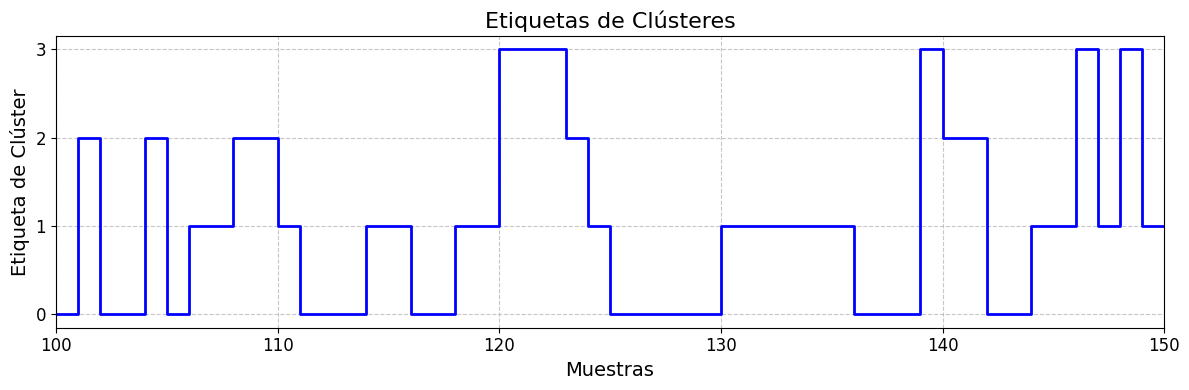

In [52]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant_eeg_simulado_adulto.shape[1]), idx_cuantico_simulado_adulto, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.xlim([100,150])
plt.tight_layout() 
plt.show()